In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing for pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [21]:
train_dir = "/home/lab-05/Documents/DL_Final_data/train"
val_dir = "/home/lab-05/Documents/DL_Final_data/val"
test_dir = "/home/lab-05/Documents/DL_Final_data/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [27]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom image loader to skip missing files
def safe_loader(path):
    if not os.path.exists(path):
        print(f"Skipping missing file: {path}")
        return None
    try:
        img = Image.open(path).convert("RGB")  # Convert grayscale images to RGB
        return img
    except Exception as e:
        print(f"Skipping corrupt image: {path} - {e}")
        return None

# Custom dataset class to handle missing images
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = safe_loader(path)
        if sample is None:
            return self.__getitem__((index + 1) % len(self.samples))  # Skip missing images
        return transform(sample), target

# Load dataset with modified ImageFolder
train_dataset = CustomImageFolder(root="/home/lab-05/Documents/DL_Final_data/train")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)


In [28]:
model = models.resnet50(pretrained=True)

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: Real and Deepfake

model = model.to(device)


In [29]:
# Define CNN Model
class DeepFakeCNN(nn.Module):
    def __init__(self, input_size=128):  # Default input size 128x128
        super(DeepFakeCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: input_size/2

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: input_size/4

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: input_size/8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: input_size/16
        )

        # Dynamically calculate flattened size
        self._to_linear = None
        self._get_conv_output(input_size)

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 2)  # Binary Classification (Real vs Deepfake)
        )

    def _get_conv_output(self, input_size):
        """ Function to calculate the output size after conv layers """
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, input_size, input_size)
            output = self.conv_layers(dummy_input)
            self._to_linear = output.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Define device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define input size (Ensure your images are resized to this)
input_size = 224  # Ensure your dataloader outputs 128x128 images
model = DeepFakeCNN(input_size).to(device)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [31]:
import os
from PIL import Image

dataset_path = "/home/lab-05/Documents/DL_Final_data/train"

for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)  # Try opening the image
            img.verify()  # Check if it's a valid image
        except Exception as e:
            print(f"Corrupt image found: {file_path} - {e}")


In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10], Loss: 0.2023, Accuracy: 90.51%
Epoch [2/10], Loss: 0.1345, Accuracy: 94.15%
Epoch [3/10], Loss: 0.0926, Accuracy: 96.19%
Epoch [4/10], Loss: 0.0615, Accuracy: 97.60%
Epoch [5/10], Loss: 0.0418, Accuracy: 98.39%
Epoch [6/10], Loss: 0.0300, Accuracy: 98.89%
Epoch [7/10], Loss: 0.0234, Accuracy: 99.14%
Epoch [8/10], Loss: 0.0181, Accuracy: 99.37%
Epoch [9/10], Loss: 0.0151, Accuracy: 99.46%
Epoch [10/10], Loss: 0.0139, Accuracy: 99.50%


In [33]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

val_acc = 100. * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 98.43%


In [34]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_acc = 100. * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 98.48%


In [37]:
import torch
from sklearn.metrics import f1_score

# Ensure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Use validation/test dataset
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'macro' if needed
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.9848


In [45]:
torch.save(model.state_dict(), "deepfake_cnn.pth")
print("Model saved successfully!")


Model saved successfully!


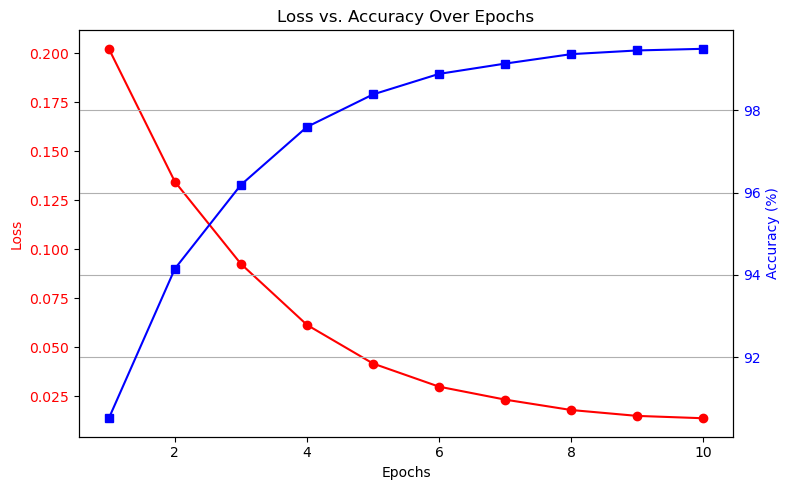

In [8]:
import matplotlib.pyplot as plt

# Data from your model
epochs = list(range(1, 11))
train_losses = [0.2023, 0.1345, 0.0926, 0.0615, 0.0418, 0.0300, 0.0234, 0.0181, 0.0151, 0.0139]
train_accuracies = [90.51, 94.15, 96.19, 97.60, 98.39, 98.89, 99.14, 99.37, 99.46, 99.50]

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color='red')
ax1.plot(epochs, train_losses, 'ro-', label="Loss")
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.plot(epochs, train_accuracies, 'bs-', label="Accuracy")
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Loss vs. Accuracy Over Epochs")
fig.tight_layout()
plt.grid()
plt.show()


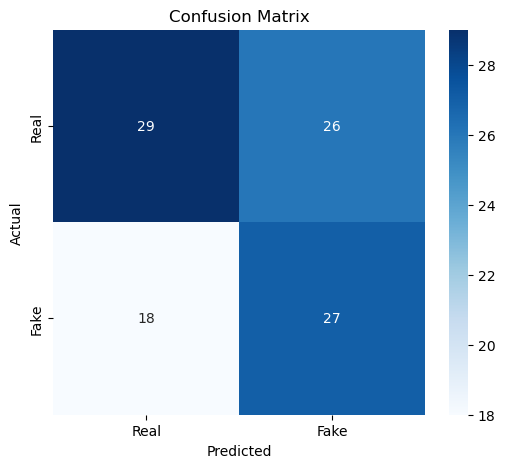

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Sample predictions and labels (Replace with your actual predictions & labels)
true_labels = np.random.randint(0, 2, size=100)  # Replace with actual labels
pred_labels = np.random.randint(0, 2, size=100)  # Replace with actual predictions

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
